In [66]:
# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse
import skimage.transform

# import custom modules
root_dir   = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root_dir,'code'))
from model_src import fwrf_fit as fwrf_fit
from model_src import fwrf_predict as fwrf_predict
from model_src import texture_statistics_gabor, texture_statistics_pyramid, bdcn_features

from model_fitting import initialize_fitting

from utils import numpy_utility, texture_utils

fpX = np.float32

In [67]:
subject=1
roi=None

ridge=0

shuffle_images=0
random_images=0
random_voxel_data=0

sample_batch_size=100
voxel_batch_size=100
zscore_features=1
nonlin_fn=0
padding_mode='circular'

n_ori=4
n_sf=4
up_to_sess=1
debug=1
shuff_rnd_seed=0
# shuff_rnd_seed=251709

fitting_type='texture'

do_fitting=1
do_val=1
do_partial=1
date_str=None

In [68]:
# Load images, and other basic things that are run at beginning of encoding model fitting

device = initialize_fitting.init_cuda()
# device = torch.device('cpu:0')
nsd_root, stim_root, beta_root, mask_root = initialize_fitting.get_paths()
model_name, feature_types_exclude = initialize_fitting.get_pyramid_model_name(ridge, n_ori, n_sf)


voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = initialize_fitting.get_voxel_info(mask_root, beta_root, subject, roi)
# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_single_trial_data, val_voxel_single_trial_data, \
    n_voxels, n_trials_val, image_order = initialize_fitting.get_data_splits(nsd_root, beta_root, stim_root, subject, voxel_mask, up_to_sess, 
                                                                             shuffle_images=shuffle_images, random_images=random_images, random_voxel_data=random_voxel_data)

batch_inds = np.arange(0,500)

images_raw_gray = trn_stim_data[batch_inds]
image_data_gray = images_raw_gray

# process_at_size=300
# images_raw_gray = skimage.transform.resize(images_raw_gray, output_shape=(images_raw_gray.shape[0],1,process_at_size, process_at_size))

# image_data_gray = bdcn_features.prep_for_bdcn(images_raw_gray, device)



# For comparison also trying w the RGB color images...
image_data, image_order = initialize_fitting.get_image_data(nsd_root, stim_root, subject, shuffle_images=False, random_images=False)
image_order = image_order[0:image_data.shape[0]]
val_inds = image_order<1000
trn_inds = image_order>=1000
# image_data = image_data[image_order[val_inds]]
image_data = image_data[image_order[trn_inds]]

images_raw_color = image_data[batch_inds]/255
image_data_color = images_raw_color
# images_raw_color = skimage.transform.resize(images_raw_color, output_shape=(images_raw_gray.shape[0],3,process_at_size, process_at_size))

# image_data_color = bdcn_features.prep_for_bdcn(images_raw_color, device)

#device: 1
device#: 0
device name: GeForce GTX 1080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32
3794 voxels of overlap between kastner and prf definitions, using prf defs
unique values in retino labels:
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]
0 voxels of overlap between face and place definitions, using place defs
unique values in categ labels:
[-1.  0. 26. 27. 28. 30. 31. 32. 33.]
1535 voxels are defined (differently) in both retinotopic areas and category areas

14913 voxels are defined across all areas, and will be used for analysis

Loading numerical label/name mappings for all ROIs:
[1, 2, 3, 4, 5, 6, 7]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2', 'TO2', 'TO1', 'LO2', 'LO1', 'V3B', 'V3A', 'IPS0', 'IPS1', 'IPS2', 

In [91]:
# Run the model here
bdcn_path = '/user_data/mmhender/toolboxes/BDCN/'
pretrained_model_file = os.path.join(bdcn_path,'params','bdcn_pretrained_on_bsds500.pth')
# pretrained_model_file = os.path.join(bdcn_path,'params','bdcn_pretrained_on_nyudv2_depth.pth')
# pretrained_model_file = os.path.join(bdcn_path,'params','bdcn_pretrained_on_nyudv2_rgb.pth')

n_prf_sd_out = 1
mult_patch_by_prf = False
feature_extractor = bdcn_features.bdcn_feature_extractor(pretrained_model_file, device, aperture_rf_range=1.1, n_prf_sd_out=n_prf_sd_out, \
                                           batch_size=10, map_ind=-1, mult_patch_by_prf=mult_patch_by_prf)
    
# maps_each_scale_gray, names = bdcn_features.get_bdcn_maps(feature_extractor.model,image_data_gray, map_inds = None)
# maps_each_scale_color, names = bdcn_features.get_bdcn_maps(feature_extractor.model,image_data_color, map_inds = None)

In [92]:
# x,y,sigma = 0.1, -0.1, 0.04
x,y,sigma = -0.2, -0.1, 0.04
prf_params = [x,y,sigma]

bbox = texture_utils.get_bbox_from_prf(prf_params, n_pix, n_prf_sd_out=n_prf_sd_out, min_pix=None, \
                                       verbose=False, force_square=False)
nf = [bbox[1] - bbox[0], bbox[3] - bbox[2]]

features = feature_extractor(image_data_gray, prf_params)

features_2d = np.reshape(features.detach().cpu().numpy(), [image_data_gray.shape[0], nf[0],nf[1]], order='C')


Running BDCN contour feature extraction...
Images array shape is:
(500, 1, 227, 227)
time elapsed = 6.42423
pRF [x,y,sigma]:
[-0.2, -0.1, 0.04]


In [71]:
image_data_gray[im2plot,0,:,:].shape

(227, 227)

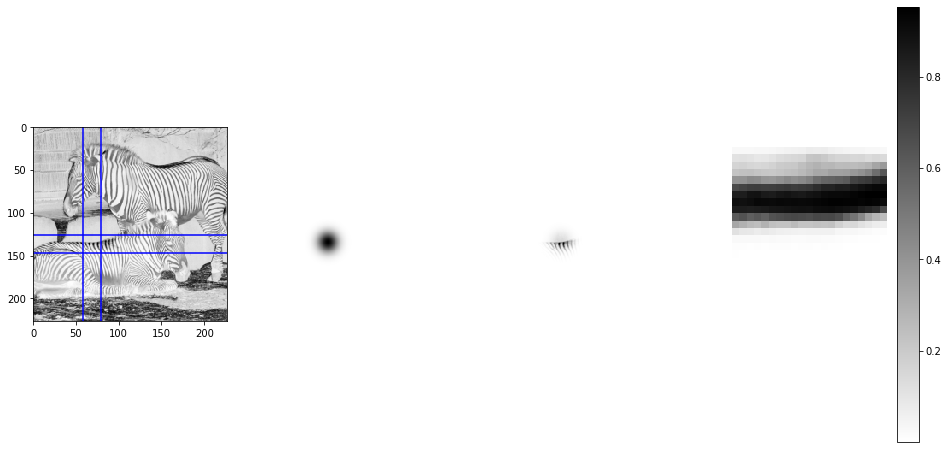

In [93]:
# extract features in an example pRF location
from matplotlib import pyplot as plt
im2plot = np.random.randint(0,500,1)[0]
im2plot = 4

aperture_rf_range = 1.1

n_pix = image_data_gray.shape[2:4]
 # Define the RF for this "model" version
_prfs = numpy_utility.make_gaussian_mass(x, y, sigma, n_pix[0], size=aperture_rf_range)
prf = _prfs[2]

features_output = features_2d[im2plot,:,:]

plt.figure(figsize=(16,8));
nplots=4

plt.subplot(1,nplots,1)
plt.pcolormesh(image_data_gray[im2plot,0,:,:], cmap='gray_r')
plt.axis('square')
# plt.axis('off')
plt.gca().invert_yaxis()
plt.axhline(bbox[0],color='b')
plt.axhline(bbox[1],color='b')
plt.axvline(bbox[2],color='b')
plt.axvline(bbox[3],color='b')

plt.subplot(1,nplots,2)
plt.pcolormesh(prf, cmap='gray_r')
plt.axis('square')
plt.axis('off')
plt.gca().invert_yaxis()


plt.subplot(1,nplots,3)
plt.pcolormesh(image_data_gray[im2plot,0,:,:]*prf, cmap='gray_r')
plt.axis('square')
plt.axis('off')
plt.gca().invert_yaxis()


plt.subplot(1,nplots,4)
plt.pcolormesh(features_output, cmap='gray_r')
plt.axis('square')
plt.axis('off')
plt.colorbar()
plt.gca().invert_yaxis()


In [37]:
def sigmoid(x):
    
    return 1/(1+np.exp(-x))

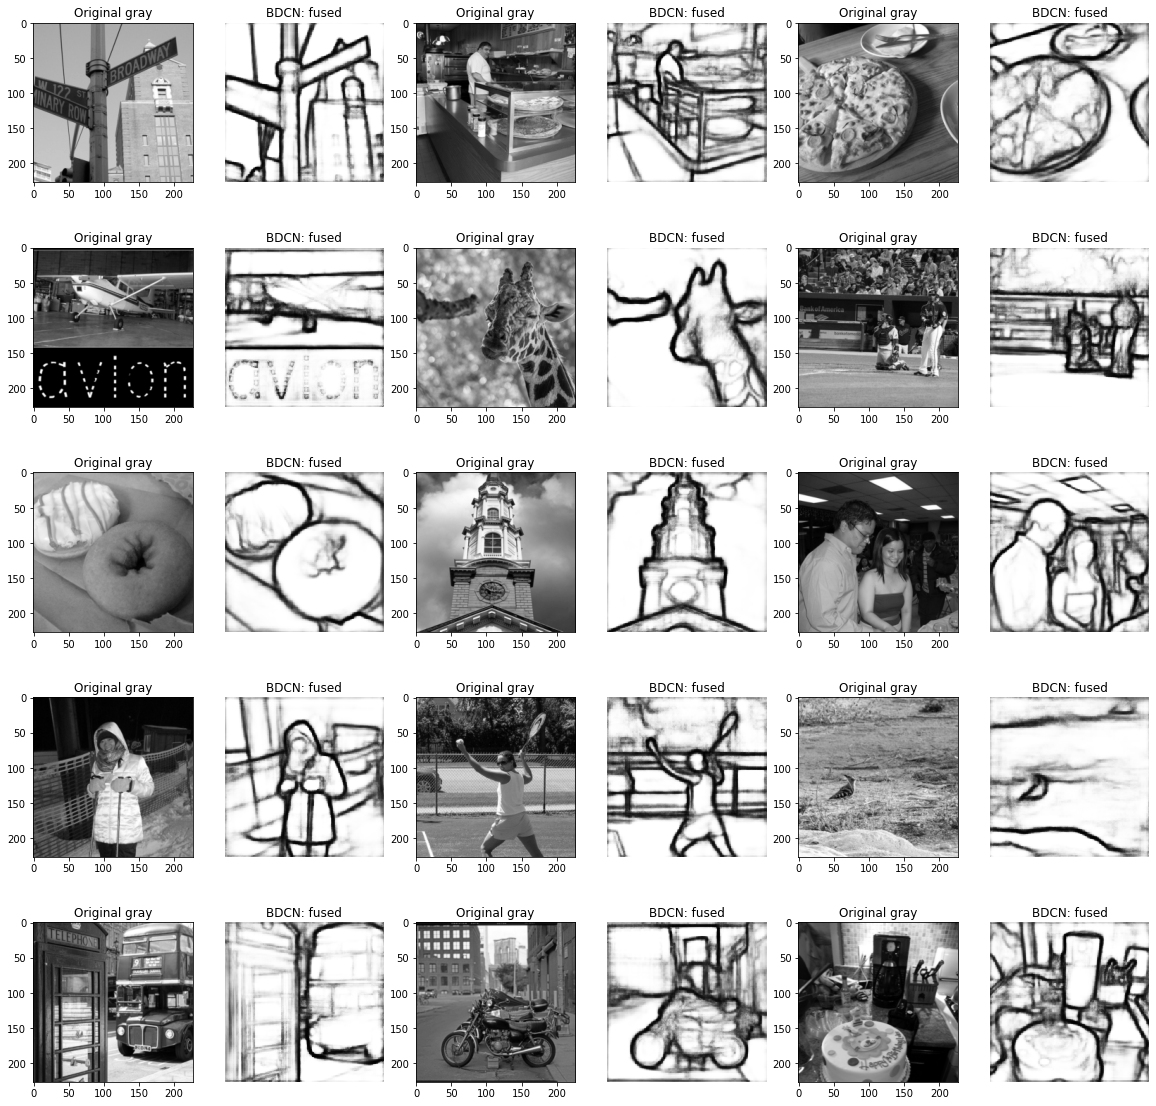

In [40]:
# Plot a bunch of examples...
ims2plot = np.random.randint(0,500,15)
from matplotlib import pyplot as plt
plt.figure(figsize=(20,20))

for ii in range(15):
    
    plt.subplot(5,6,2*ii+1)
    plt.imshow(np.moveaxis(images_raw_gray[ims2plot[ii]],[0],[2],), cmap = 'gray')
    plt.title('Original gray')
    
    plt.subplot(5,6,2*ii+2)
    map2plot = sigmoid(maps_each_scale_gray[-1])[ims2plot[ii],0,:,:]
    plt.pcolormesh(map2plot,cmap='gray_r')

    plt.title(names[-1])
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()


In [15]:
maps_each_scale_gray[-1].shape

(10, 1, 227, 227)

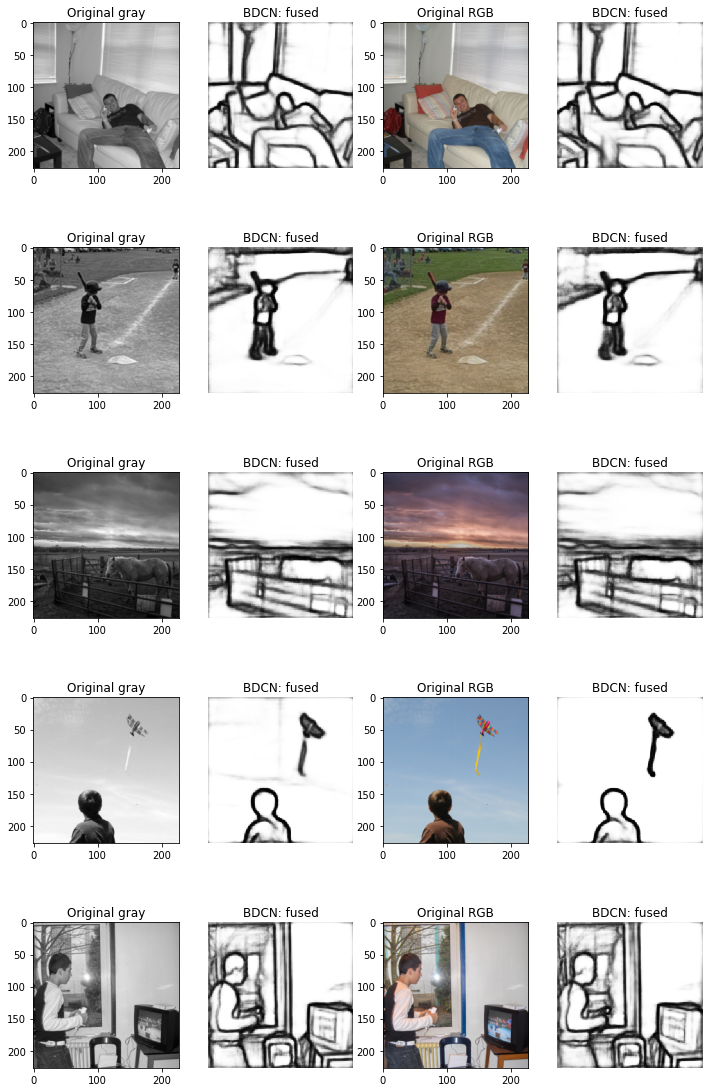

In [9]:
# Compare RGB versus grayscale images...

ims2plot = np.random.randint(0,500,5)

from matplotlib import pyplot as plt
plt.figure(figsize=(12,20))

for ii in range(5):
    
    plt.subplot(5,4,4*ii+1)
    plt.imshow(np.moveaxis(images_raw_gray[ims2plot[ii]],[0],[2],), cmap = 'gray')
    plt.title('Original gray')
    
    plt.subplot(5,4,4*ii+2)
    map2plot = sigmoid(maps_each_scale_gray[-1])[ims2plot[ii],0,:,:]
    plt.pcolormesh(map2plot,cmap='gray_r')

    plt.title(names[-1])
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()

    plt.subplot(5,4,4*ii+3)
    plt.imshow(np.moveaxis(images_raw_color[ims2plot[ii]],[0],[2]))
    plt.title('Original RGB')
    
    plt.subplot(5,4,4*ii+4)
    map2plot = sigmoid(maps_each_scale_color[-1])[ims2plot[ii],0,:,:]
    plt.pcolormesh(map2plot,cmap='gray_r')

    plt.title(names[-1])
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()

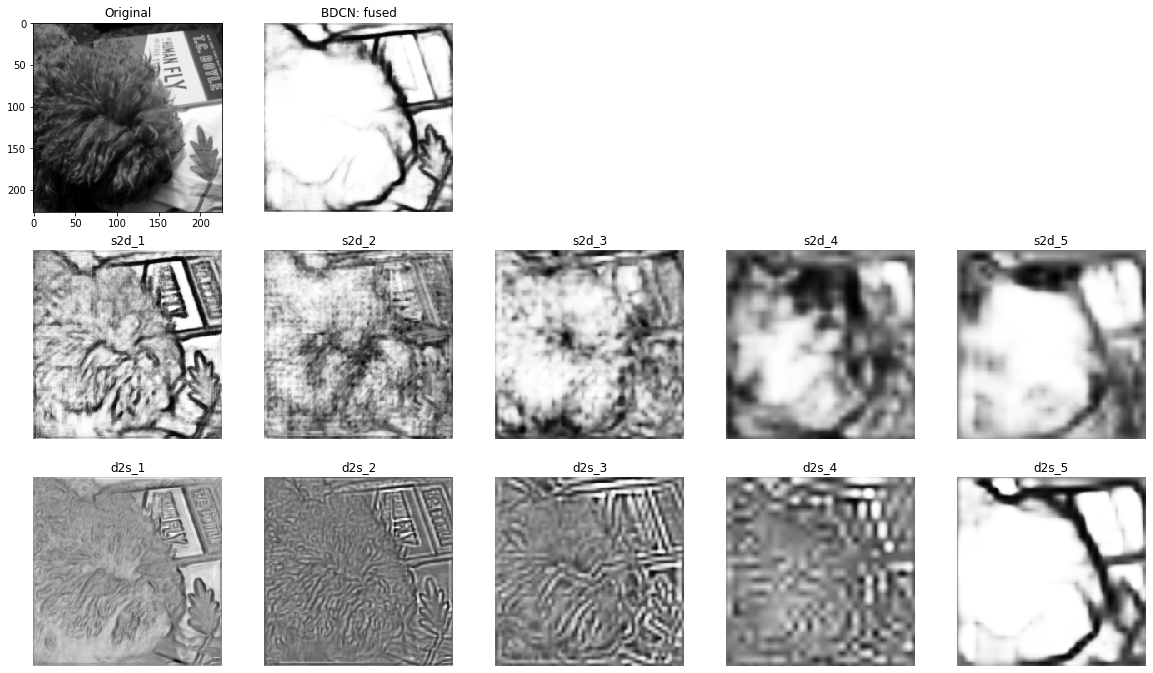

In [42]:
# Plot the results, including intermediate maps at each scale.

im2plot = np.random.randint(0,500)

from matplotlib import pyplot as plt
plt.figure(figsize=(20,16))

plt.subplot(4,5,1)
plt.imshow(np.moveaxis(images_raw_gray[im2plot],[0],[2]), cmap='gray')
plt.title('Original')


plt.subplot(4,5,2)
map2plot = sigmoid(maps_each_scale_gray[-1])[im2plot,0,:,:]

plt.pcolormesh(map2plot,cmap='gray_r')

plt.title(names[-1])
plt.axis('square')
plt.axis('off')
plt.gca().invert_yaxis()

for ii in range(10):
    
    plt.subplot(4,5,ii+6)

    map2plot = sigmoid(maps_each_scale_gray[ii])[im2plot,0,:,:]
    
#     plt.pcolormesh(map2plot,cmap='gray_r', vmin=0,vmax=1)
    plt.pcolormesh(map2plot,cmap='gray_r')
    
#     plt.colorbar()
#     print([np.min(map2plot), np.max(map2plot)])
    plt.title(names[ii])
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()


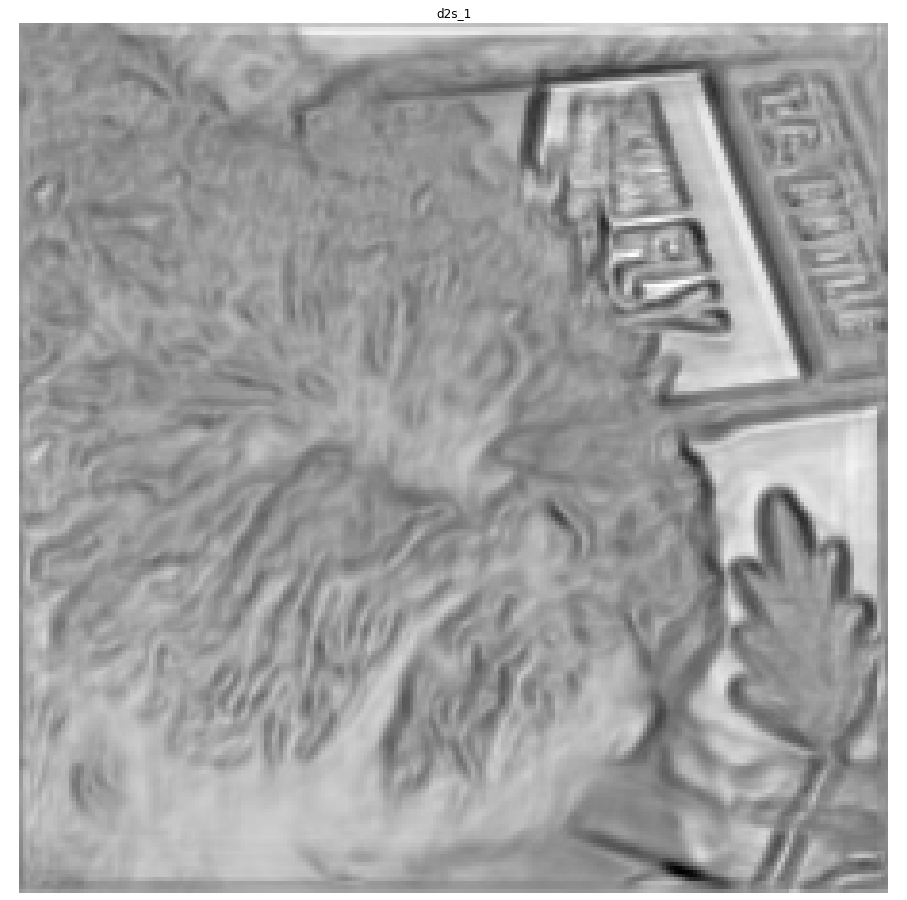

In [43]:
ii=5
plt.figure(figsize=(16,16))
map2plot = sigmoid(maps_each_scale_gray[ii])[im2plot,0,:,:]
plt.pcolormesh(map2plot,cmap='gray_r')
plt.title(names[ii])
plt.axis('equal')
plt.axis('off')
plt.gca().invert_yaxis()

pRF [x,y,sigma]:
[-0.55, 0.55, 0.04]
64


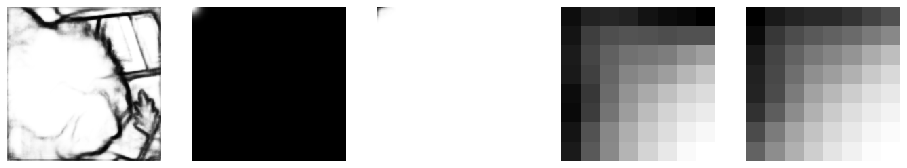

In [51]:
# Apply spatial RFs to the feature maps
from utils import torch_utils, numpy_utility, texture_utils

aperture_rf_range = 1.1
# aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    
# x,y,sigma = 0.1, -0.1, 0.09
x,y,sigma = -0.55, 0.55, 0.04
prf_params = [x,y,sigma]

print('pRF [x,y,sigma]:')
print([x,y,sigma])

aperture = aperture_rf_range
fmaps_rez = [227]

 # Define the RF for this "model" version
_prfs = [torch_utils._to_torch(numpy_utility.make_gaussian_mass(x, y, sigma, n_pix, size=aperture, \
                          dtype=np.float32)[2], device=device) for n_pix in fmaps_rez]

prf = _prfs[0].cpu().numpy()

map_ind = -1

maps_in_prf = sigmoid(maps_each_scale_gray[map_ind]) * prf

bbox = texture_utils.get_bbox_from_prf(prf_params, prf.shape, n_prf_sd_out=2, min_pix=None, verbose=False, force_square=False)

maps_in_prf_cropped  = maps_in_prf[:,:,bbox[0]:bbox[1], bbox[2]:bbox[3]]


map2plot = sigmoid(maps_each_scale_gray[map_ind])[im2plot,0,:,:]

plt.figure(figsize=(16,8));
nplots=5

plt.subplot(1,nplots,1)
plt.pcolormesh(map2plot, cmap='gray_r')
plt.axis('square')
plt.axis('off')
plt.gca().invert_yaxis()

plt.subplot(1,nplots,2)
plt.pcolormesh(prf, cmap='gray')
plt.axis('square')
plt.axis('off')
plt.gca().invert_yaxis()


plt.subplot(1,nplots,3)
plt.pcolormesh(maps_in_prf[im2plot,0,:,:], cmap='gray_r')
plt.axis('square')
plt.axis('off')
plt.gca().invert_yaxis()

map_cropped = (map2plot)[bbox[0]:bbox[1], bbox[2]:bbox[3]]

plt.subplot(1,nplots,4)
plt.pcolormesh(map_cropped, cmap='gray_r')
plt.axis('square')
plt.axis('off')
plt.gca().invert_yaxis()

map_cropped = maps_in_prf_cropped[im2plot,0,:,:]

plt.subplot(1,nplots,5)
plt.pcolormesh(map_cropped, cmap='gray_r')
plt.axis('square')
plt.axis('off')
plt.gca().invert_yaxis()


print(np.prod(np.shape(maps_in_prf_cropped)[2:4]))

In [39]:
x,y,sigma = [0,0,0.4]
# Define the RF for this "model" version
_prfs = [torch_utils._to_torch(numpy_utility.make_gaussian_mass(x, y, sigma, n_pix, size=aperture, \
                          dtype=np.float32)[2], device=device) for n_pix in fmaps_rez]

prf = _prfs[0].cpu().numpy()
bbox = texture_utils.get_bbox_from_prf(prf_params, prf.shape, n_prf_sd_out=2, min_pix=None, verbose=False, force_square=False)


In [13]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(features)
scores = pca.transform(features)
wts = pca.components_
ev = pca.explained_variance_
ev = ev/np.sum(ev)*100

Text(0, 0.5, 'Percent var explained (cumulative)')

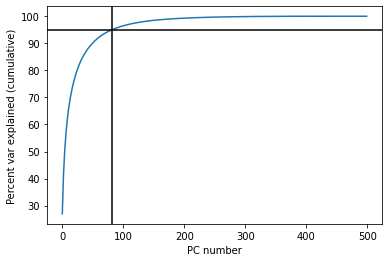

In [14]:
plt.figure;
plt.plot(np.cumsum(ev))
ncomp = np.where(np.cumsum(ev)>95)[0][0]
plt.axhline(95,color='k')
plt.axvline(ncomp,color='k')
plt.xlabel('PC number')
plt.ylabel('Percent var explained (cumulative)')

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if __name__ == '__main__':


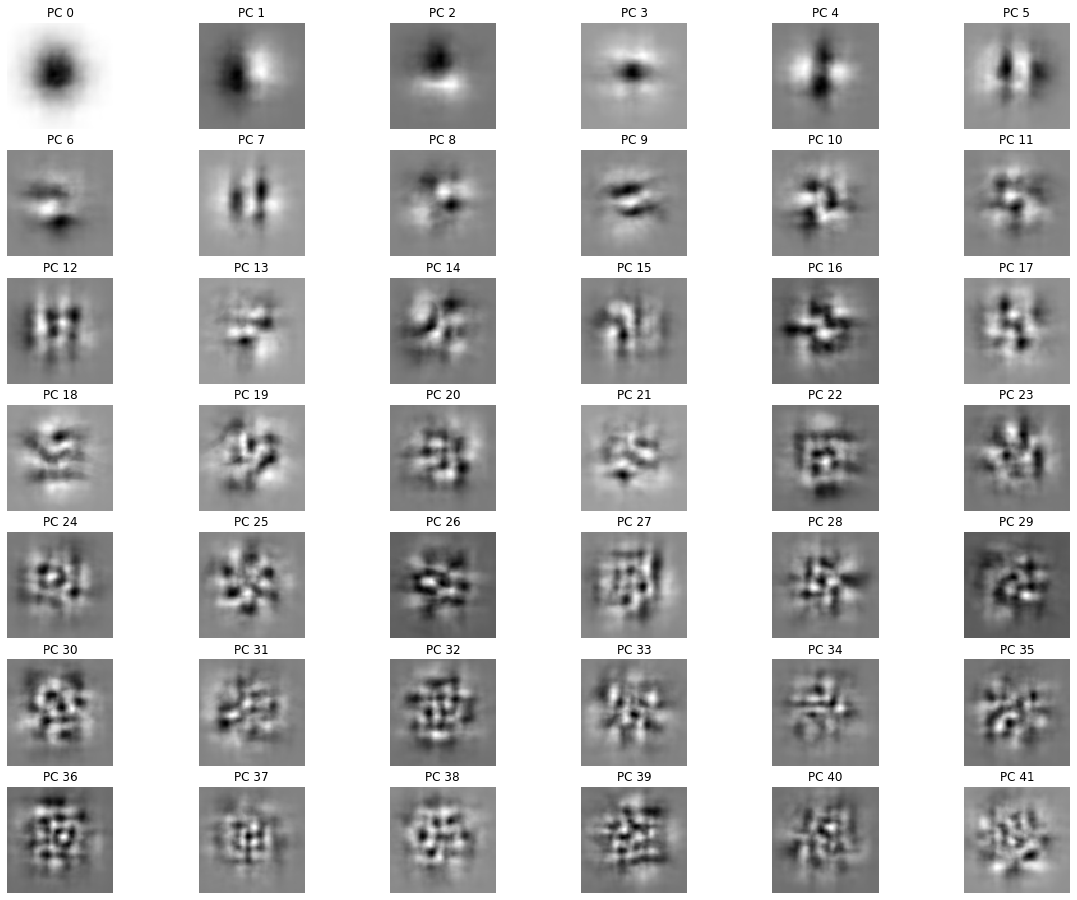

In [15]:
ncomp2plot = 42
npx = np.ceil(np.sqrt(ncomp2plot))
npy = np.ceil(ncomp2plot/npx)
mapsize = [83,83]

plt.figure(figsize=(20,16))
for ii in range(ncomp2plot):
    
    plt.subplot(npx, npy, ii+1)
    pcmap = np.reshape(wts[ii], mapsize, order='F')
    
    plt.pcolormesh(pcmap, cmap = 'gray_r')
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.title('PC %d'%ii)


#device: 1
device#: 0
device name: GeForce GTX 1080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


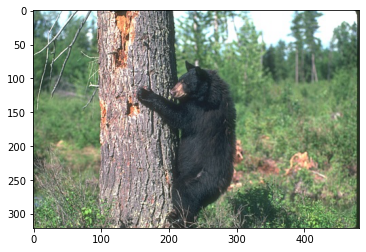

In [17]:
# Load an example from BSD500 set

from PIL import Image
from matplotlib import pyplot as plt

device = initialize_fitting.init_cuda()

img_file = '/user_data/mmhender/toolboxes/BSR/BSDS500/data/images/test/100039.jpg'
img = Image.open(img_file)
img = np.reshape(img.getdata(), [img.size[1], img.size[0],3])

img = np.expand_dims(np.moveaxis(img, [0,1,2], [1,2,0]),axis=0)

plt.figure();
plt.imshow(np.moveaxis(img[0],[0],[2]))
# plt.pcolormesh(np.mean(dat[0,:,:,:], axis=0),cmap='gray_r')
# plt.gca().invert_yaxis()

dat = img/255

import scipy
gt_file = img_file = '/user_data/mmhender/toolboxes/BSR/BSDS500/data/groundTruth/test/100039.mat'
gt = scipy.io.loadmat(gt_file)

gtmaps = [g[0][0][0] for g in gt['groundTruth'][0]]

pretrained_model_file = os.path.join(bdcn_path,'params','bdcn_pretrained_on_bsds500.pth')
# pretrained_model_file = os.path.join(bdcn_path,'params','bdcn_pretrained_on_nyudv2_depth.pth')
# pretrained_model_file = os.path.join(bdcn_path,'params','bdcn_pretrained_on_nyudv2_rgb.pth')

feature_extractor = bdcn_features.bdcn_feature_extractor(pretrained_model_file, device, aperture_rf_range=1.1, n_prf_sd_out=2, \
                                           batch_size=10, map_ind=-1)
    
maps_each_scale, names = bdcn_features.get_bdcn_maps(feature_extractor.model, dat, map_inds = None)
 

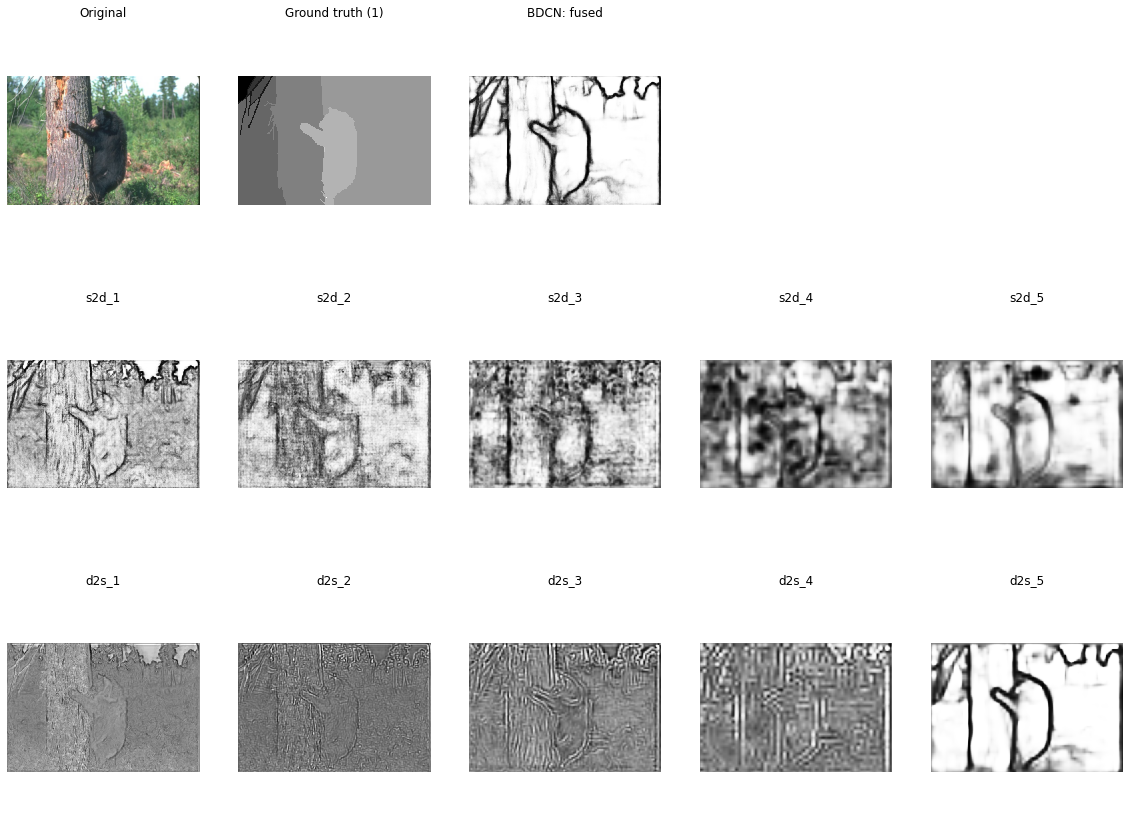

In [18]:
# Plot the results, including intermediate maps at each scale.

im2plot = 0

from matplotlib import pyplot as plt
plt.figure(figsize=(20,20))

plt.subplot(4,5,1)
plt.imshow(np.moveaxis(img[im2plot,:,:,:],[0],[2]),cmap='gray')
plt.title('Original')
plt.axis('equal')
plt.axis('off')

plt.subplot(4,5,2)
gg=0
plt.pcolormesh(gtmaps[gg], cmap='gray',clim=[0,255])
plt.axis('equal')
plt.axis('off')
plt.title('Ground truth (%d)'%(gg+1))
plt.gca().invert_yaxis()

plt.subplot(4,5,3)
map2plot = sigmoid(maps_each_scale[-1])[im2plot,0,:,:]
plt.pcolormesh(map2plot,cmap='gray_r')
plt.title(names[-1])
plt.axis('equal')
plt.axis('off')
plt.gca().invert_yaxis()

for ii in range(10):
    
    plt.subplot(4,5,ii+6)

    map2plot = sigmoid(maps_each_scale[ii])[im2plot,0,:,:]
    
#     plt.pcolormesh(map2plot,cmap='gray_r', vmin=0,vmax=1)
    plt.pcolormesh(map2plot,cmap='gray_r')
    
#     plt.colorbar()
#     print([np.min(map2plot), np.max(map2plot)])
    plt.title(names[ii])
    plt.axis('equal')
    plt.axis('off')
    plt.gca().invert_yaxis()
